<a href="https://colab.research.google.com/github/kazishuvo22/fastMRI-Reconstruction/blob/master/test_data2npy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loads test data and convert to npy for running predictions

In [3]:
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
import support as s
from tqdm import tqdm
import tensorflow as tf
from fastMRI.data import transforms as T

from fastMRI.common.subsample import RandomMaskFunc


As there is missing fastmri folder
from fastMRI.data import transforms as T

from fastMRI.common.subsample import RandomMaskFunc

In [4]:
TEST_DIR_PATH  = "dataset/test"

In [5]:
TEST_IMAGES_DIR_PATH  = glob.glob(os.path.join(TEST_DIR_PATH,"*.h5"))
len(TEST_IMAGES_DIR_PATH )

15

In [6]:
def sub_sample_kspace(vol, mask_func):
    """
    Transform a kpsace tensor to an undersampled 3D image using mask object 4x or 8x.
    Args:
        vol: kspace tensor
        mask_func: mask function object (4x, 8x)
    Returns:
        sampled_image: output undersampled 3D image volume
    """
    
    # 1. convert numpy to torch tensor
    kspace2ttensor = T.to_tensor(vol)
    
    ### NO MASKING IN TEST DATA AS IT IS ALREADY UNDERSAMPLED
    # 2. apply mask to kspace
    #masked_kspace, mask = T.apply_mask(kspace2ttensor, mask_func)   
    
    # 3. inverse fast fourier transform 2D
    sampled_image = T.ifft2(kspace2ttensor)
    
    # 4. compute absolute value to get a real image
    sampled_image_abs = T.complex_abs(sampled_image)
    
    # 5. centre crop to 320x320
    cropped_image = T.center_crop(sampled_image_abs, (320, 320))
    
    # 6. Normalize
    #cropped_image_norm, _, _ = T.normalize_instance(cropped_image)

    # 7. convert torch tensor to good old numpy array
    sampled_image = np.abs(cropped_image.numpy())
    
    return sampled_image


def show_slices(data, slice_nums, cmap=None):
    fig = plt.figure(figsize=(16, 16))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [7]:
TEST_IMAGES_DIR_PATH[0]

'dataset/test\\file1002461.h5'

In [8]:
file = TEST_IMAGES_DIR_PATH[0]
hf = h5py.File(file)
print(type(hf))

<class 'h5py._hl.files.File'>


C:\Users\rtapz\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


In [9]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPDFS_FBK', 'max': 0.00023466069523489145, 'norm': 0.051801350182685786, 'patient_id': '3aa0050518fd165c2d7b150c8f6fb8f6c023ed2137fbba0059ef4fb95750e4dc'}


In [ ]:
#mask = hf['mask']
#mask


##Kspace tensor

In [10]:
kspace_tensor = hf['kspace'][()]
print(kspace_tensor.shape)
img_3d = sub_sample_kspace(kspace_tensor, _)
print(img_3d.shape)

(34, 640, 372)
(34, 320, 320)


I:\CSE499\fastMRI-Reconstruction\fastMRI\data\transforms.py:84: UserWarning: The function torch.ifft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.ifftn. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:578.)
  data = torch.ifft(data, 2, normalized=True)


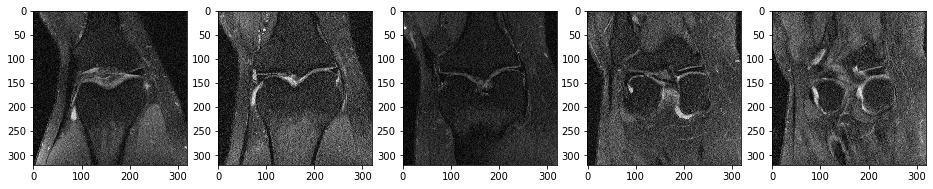

In [11]:
slice_num = [12, 16, 19, 22, 24]
show_slices(img_3d, slice_num, cmap='gray')

2.58244e-08 0.00023466069


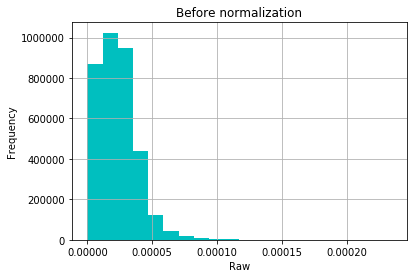

In [12]:
img_flat = img_3d.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("Before normalization")
plt.xlabel("Raw")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

In [13]:
a = s.normalize(img_3d)
a.shape

(34, 320, 320)

0.0 1.0


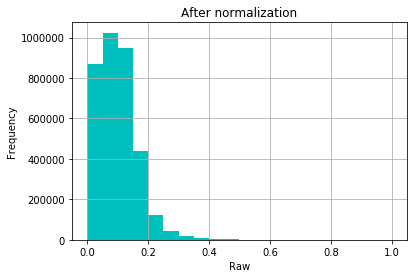

In [14]:
img_flat = a.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("After normalization")
plt.xlabel("Raw")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

In [15]:
# go back to original distribution
c = a * 0.00035430153 + 1.2043776e-08
c.shape

(34, 320, 320)

1.2043776e-08 0.00035431358


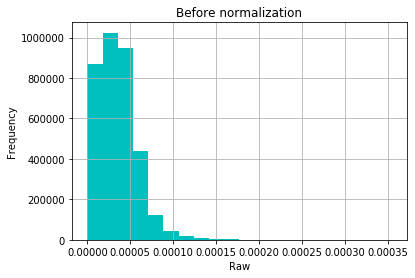

In [16]:
img_flat = c.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("Before normalization")
plt.xlabel("Raw")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

In [23]:
test_npy_path ="dataset/testNpyFromTrain/"

In [24]:
i=0
for file in tqdm(TEST_IMAGES_DIR_PATH[:]):
    i+=1
    
    hf = h5py.File(file)
    
    # transform and save low res image volume
    kspace_tensor = hf['kspace'][()]
    img_3d = sub_sample_kspace(kspace_tensor, _)
    
    # Save 
    np.save("{}/f{}.npy".format(test_npy_path, file[-16:-3]), img_3d) 

    # Show progress
    print(i, file, "raw data - ", kspace_tensor.shape, "--", "input test volume - ", img_3d.shape)


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]C:\Users\rtapz\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """
  7%|█████▌                                                                             | 1/15 [00:00<00:10,  1.35it/s]

1 dataset/test\file1002461.h5 raw data -  (34, 640, 372) -- input test volume -  (34, 320, 320)


 13%|███████████                                                                        | 2/15 [00:01<00:07,  1.66it/s]

2 dataset/test\file1002469.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 20%|████████████████▌                                                                  | 3/15 [00:01<00:06,  1.98it/s]

3 dataset/test\file1002475.h5 raw data -  (36, 640, 372) -- input test volume -  (36, 320, 320)


 27%|██████████████████████▏                                                            | 4/15 [00:01<00:04,  2.33it/s]

4 dataset/test\file1002476.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 33%|███████████████████████████▋                                                       | 5/15 [00:01<00:04,  2.43it/s]

5 dataset/test\file1002478.h5 raw data -  (38, 640, 372) -- input test volume -  (38, 320, 320)


 40%|█████████████████████████████████▏                                                 | 6/15 [00:02<00:03,  2.74it/s]

6 dataset/test\file1002479.h5 raw data -  (28, 640, 372) -- input test volume -  (28, 320, 320)


 47%|██████████████████████████████████████▋                                            | 7/15 [00:02<00:02,  2.97it/s]

7 dataset/test\file1002485.h5 raw data -  (34, 640, 372) -- input test volume -  (34, 320, 320)


 53%|████████████████████████████████████████████▎                                      | 8/15 [00:02<00:02,  3.22it/s]

8 dataset/test\file1002491.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:02<00:01,  3.29it/s]

9 dataset/test\file1002497.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:03<00:01,  3.22it/s]

10 dataset/test\file1002499.h5 raw data -  (36, 640, 372) -- input test volume -  (36, 320, 320)


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [00:03<00:01,  3.39it/s]

11 dataset/test\file1002509.h5 raw data -  (34, 640, 372) -- input test volume -  (34, 320, 320)


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [00:03<00:00,  3.34it/s]

12 dataset/test\file1002511.h5 raw data -  (34, 640, 372) -- input test volume -  (34, 320, 320)


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [00:04<00:00,  3.39it/s]

13 dataset/test\file1002517.h5 raw data -  (33, 640, 372) -- input test volume -  (33, 320, 320)


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:04<00:00,  3.60it/s]

14 dataset/test\file1002534.h5 raw data -  (30, 640, 372) -- input test volume -  (30, 320, 320)


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.22it/s]

15 dataset/test\file1002537.h5 raw data -  (32, 640, 372) -- input test volume -  (32, 320, 320)


In [26]:
test_path = glob.glob(os.path.join("dataset/testNpyFromTrain/ft","*.npy"))
len(test_path)

15

In [27]:
test_path[:4]

['dataset/testNpyFromTrain/ft\\file1002461.npy',
 'dataset/testNpyFromTrain/ft\\file1002469.npy',
 'dataset/testNpyFromTrain/ft\\file1002475.npy',
 'dataset/testNpyFromTrain/ft\\file1002476.npy']